# BE: VAE on MNIST for image restoration (BE noté)

### Context
We consider here the problem of image restoration, such as denoising, deblurring, inpainting or super-resolution. We can model such a problem by $y = A x + n,$ where $y$ is the (corrupted) image, $x$ denotes the clean image and $n$ represents some measurement noise. Operator $A$ is often known with a high precision, it can be for instance 
- a mask (inpainting)
- a convolution with the sensor PSF (deblurring)
- the identity (denoising)
- a blur followed by spatial subsampling (super-resolution)
- etc

Assuming zero-mean Gaussian noise, we estimate the clean image by the following optimization procedure :
\begin{equation}
\hat x = \arg \min_x \frac{1}{2} \| y - Ax \|_2^2 + \varphi(x)
\end{equation}
We indeed seek to minimize a least-square data-fitting term, complemented by a regularization that should promote some particular behavior of the solution. If we assume that $p(x)= e^{-\varphi(x)}$, then we recover the Bayesian maximum a posteriori (MAP) estimator of $x$. 

In practice, it is difficult to find good priors $\varphi$ for images, since these are complex and high-dimensional data. Generative (deep) neural networks offer a nice and effective way, as remarked in (Bora et al) in 2017. The idea is to pre-train an encoder-decoder on a representative dataset, so that it maps an image x to a latent vector z which is often assumed to be Gaussian. Then, the estimation problem can be done in the latent space:
\begin{equation}
\hat z = \arg \min_z \frac{1}{2} \| y - A D(z) \|_2^2 + \lambda \|z\|_2^2.
\end{equation}



### Outline
In this lab, you will successively:

1. Learn a (simple) generative model
2. Apply it to image denoising
3. Apply it to a inverse problem using the approach in (Bora et al)
4. Test the same approach on more complex images using a pre-trained model from (Asim et al.)

Steps 1 to 3 can be done on a laptop with a CPU. For step 4, depending on the complexity of the chosen model, you might need to use Google colab.

### Instructions
- Groups of 1 or 2 students
- Upload your final notebook (with all outputs) on Moodle. If needed, you can split in several notebooks and/or python codes, in particular for part 4. In that case, please put some Figures in the main notebook, and upload a zip file containing all the code (notebook + scripts)
- Deadline : Sunday 28th

### Useful references and sources
- Kingma and Welling, <a href="https://arxiv.org/abs/1312.6114">Auto-Encoding Variational Bayes</a>, ICLR 2014
- Bora et al., <a href="https://arxiv.org/pdf/1703.03208.pdf">Compressed Sensing using Generative Models</a>, ICML 2017
- Asim et al., <a href="http://proceedings.mlr.press/v119/asim20a/asim20a.pdf"> Invertible generative models for inverse problems: mitigating representation error and dataset bias, ICML 2020

In [20]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

## 1. Training a VAE on MNIST
### Loader

In [3]:
batch_size = 128

# Snipet to allow downloading from Yann Lecun website. 
# If this fails, download it directly from another source
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
train_loader = DataLoader(MNIST('data/', train=True, download=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MNIST('data/', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

In [5]:
# Img shape
train_loader.dataset.data[0].shape, train_loader.dataset.data[0].shape[0]*train_loader.dataset.data[0].shape[1]

(torch.Size([28, 28]), 784)

### Model
We use here a simple variational Auto-encoder (VAE). Since we will work on the simple MNIST dataset we will use a shwallow architecture with FC layers. On more complex image we would need a deeper and convolutional model.
While the architecture is quite straightforward, pay attention to the loss function and the reparametrization

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 500),
            nn.Softplus(beta=1, threshold=20),
            nn.Linear(500, 500),
            nn.Softplus(beta=1, threshold=20)
        )
        
        self.mu = nn.Linear(500, 20)
        self.logvar = nn.Linear(500, 20)
        
        self.decoder = nn.Sequential(
            nn.Linear(20, 500),
            nn.Softplus(beta=1, threshold=20),
            nn.Linear(500, 500),
            nn.Softplus(beta=1, threshold=20),
            nn.Linear(500,784),
            nn.Sigmoid()
        )

    def encode(self, x):
        y = self.encoder(x)
        return self.mu(y), self.logvar(y)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss and optimizer
Remember what a VAE is. Ideally, we would like to maximize the posterior distribution. We use a lower bound instead, called the ELBO. 

In [7]:
lr = 0.001 # learning rate
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

def loss_function(decoded_x, x, mu, logvar):
    RE = torch.nn.BCELoss(reduction='sum')(decoded_x, x)
    KLD = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RE + KLD


In [8]:
epochs = 30

### Training
This ok with a standard CPU (takes a few minutes at most)

In [41]:
from tqdm.autonotebook import tqdm, trange
train_losses = []

for epoch in trange(epochs, desc="Epoch"):
    model.train()
    train_loss = 0
    for i, (X_batch, _) in enumerate(train_loader):
        X_batch = X_batch.to(device).view(X_batch.shape[0], 784)
        
        # forward
        X_pred, mu, logvar = model(X_batch)
        loss = loss_function(X_pred, X_batch, mu, logvar)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_losses.append(train_loss / len(train_loader.dataset))
            
    tqdm.write('Epoch: {} - Train loss: {}'.format(epoch, train_losses[-1]))



Epoch: 0 - Train loss: 103.72406637369792


Epoch: 1 - Train loss: 103.19051362304687


Epoch: 2 - Train loss: 102.73622490234375


Epoch: 3 - Train loss: 102.33348642578125


Epoch: 4 - Train loss: 101.89568022460938


Epoch: 5 - Train loss: 101.57660182291667


Epoch: 6 - Train loss: 101.2666892578125


Epoch: 7 - Train loss: 100.98666398111979


Epoch: 8 - Train loss: 100.78899801432291


Epoch: 9 - Train loss: 100.47442306315104


Epoch: 10 - Train loss: 100.2963486328125


Epoch: 11 - Train loss: 100.06533193359375


Epoch: 12 - Train loss: 99.83130841471355


Epoch: 13 - Train loss: 99.68366069335937


Epoch: 14 - Train loss: 99.52367107747396


Epoch: 15 - Train loss: 99.311733984375


Epoch: 16 - Train loss: 99.12102827148438


Epoch: 17 - Train loss: 98.98284604492187


Epoch: 18 - Train loss: 98.85158754882812


Epoch: 19 - Train loss: 98.67805004882813


Epoch: 20 - Train loss: 98.52683499348959


Epoch: 21 - Train loss: 98.44284915364584


Epoch: 22 - Train loss: 98.31426

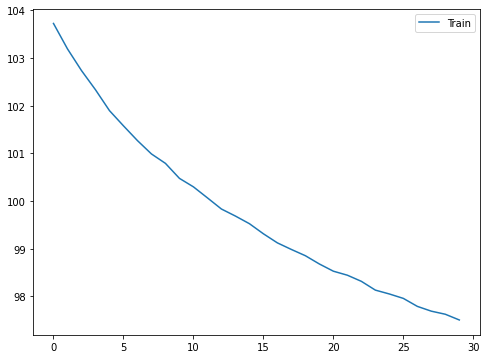

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train')
plt.legend();

### Save or load the model

In [9]:
# Save the trained model
filename = "20210322"
# torch.save(model.state_dict(), '{}/{}_VAE.pth'.format('models', filename))

# Load a pre-trained model
model.load_state_dict(torch.load('{}/{}_VAE.pth'.format('models', filename), map_location=device))

<All keys matched successfully>

### Evaluation

In [10]:
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (X_batch, _) in enumerate(test_loader):
        # resize images
        X_batch = X_batch.to(device).view(X_batch.size(0), 784)
        # forward
        X_pred, mu, logvar = model(X_batch)
        test_loss += loss_function(X_pred, X_batch, mu, logvar).item()
        
        # Get first n images from the test set and their approximation via the VAE for display
        if i == 0:
            n = min(X_batch.size(0), 8)
            comparison = torch.cat([X_batch.view(X_batch.size(0), 28, 28)[:n], X_pred.view(X_batch.size(0), 28, 28)[:n]])
            img = comparison.cpu().numpy()

print(f'Test loss: {test_loss/len(test_loader.dataset):.2f}')

Test loss: 99.34


### Display MNIST images

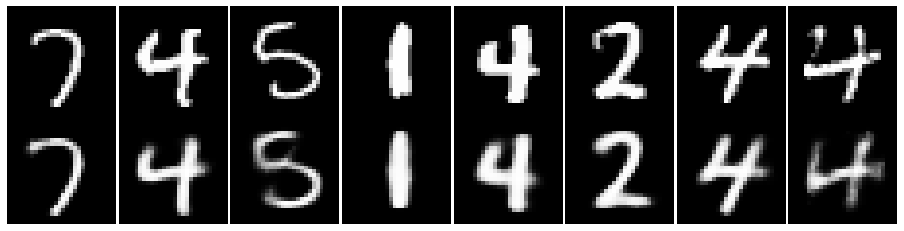

In [11]:
def plot_img(img,n):
    h = img.shape[0] // n
    fig, ax = plt.subplots(h, n, figsize=(16, 2*h))
    for j in range(h):
        for i in range(n):
            ax[j,i].imshow((img[j*n+i]*255.).clip(0,255).astype('uint8'), cmap='gray')
            ax[j,i].axis('off')
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

# Display the images from the test set.
# Top: true image. Bottom: reconstructed (D(E(x))
plot_img(img,n)

### Exploration of the latent space

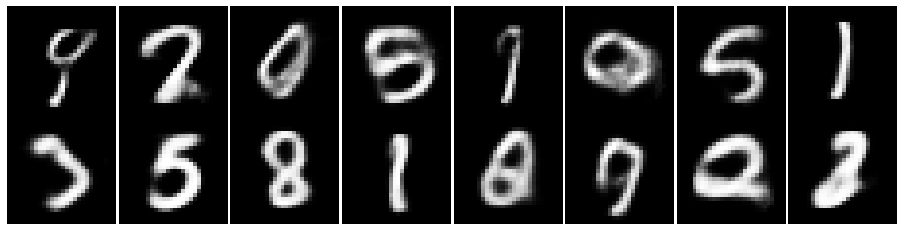

In [12]:
with torch.no_grad():
    z = torch.randn(n*2, 20).to(device)
    sample = model.decode(z).view(-1, 28, 28).cpu().numpy()

# Examples of images samples from the VAE
plot_img(sample,n)

## 2. Application to image denoising
We will now test the network for denoising purpose. Let us start by redefining a data loader for the test set. To begin with, you might process only the first batch of 8 images.

In [13]:
batch_size = 8
latent_dim = 20
test_loader = DataLoader(MNIST('data', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
X_batch, _ = next(iter(test_loader))

<font color='red'>Exercise:</font> pick some images from the test set, create noisy versions, and see the effect of a forward pass over the network. Compute the average MSE or PSNR over the first batch (or the entire set)

sig=tensor(0.3487)


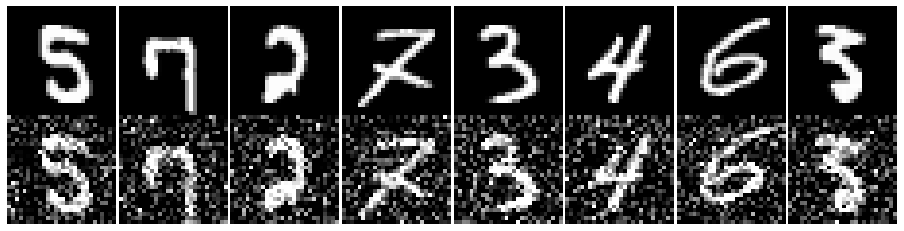

In [14]:
# Your answer
X_batch = X_batch.to(device).view(X_batch.size(0), 784)
_, sig = X_batch[0].mean(), X_batch[0].std()
print(f"{sig=}")
noisy_imgs = torch.zeros_like(X_batch)
for i, img in enumerate(X_batch):
    noisy_imgs[i] = img + sig*torch.randn_like(img)

comparaison = torch.cat([X_batch.view(X_batch.size(0), 28, 28)[:n], noisy_imgs.view(noisy_imgs.size(0), 28, 28)[:n]])
img = comparaison.cpu().numpy()
plot_img(img, 8)

In [18]:
from sklearn.metrics import mean_squared_error
print(f"MSe on the first batch: {mean_squared_error(X_batch, noisy_imgs):.3f}")

MSe on the first batch: 0.124


We will now investigate a different approach for image denoising: with a gradient descent, we will denoise the images by finding the latent code $z$ which best fits the noisy image, in the least-square sense.

In the following cells, we define some parameters and then apply the denoising technique to the images in the first minibatch.

100%|██████████| 500/500 [00:00<00:00, 555.51it/s]


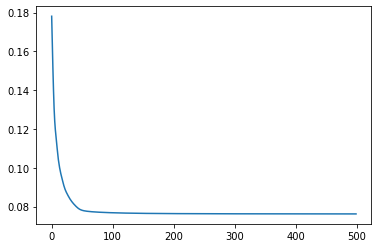

In [21]:
epochs = 500 # Number of iterations of the gradient descent
lambda_ = 1e-3 # Lambda parameter for extra regularization
lr = 100 # learning rate
sigma = 0.25 # std of the noise we will simulate in the images
mse_tot = []

# Get test data, add noise
y = X_batch.to(device).view(batch_size, 28*28)
y_n = y + sigma*torch.randn_like(y)

# random init
z = torch.randn(batch_size,latent_dim).requires_grad_()
# Gradient descent      
for e in trange(epochs):
    y_ = model.decode(z)
    mse = torch.mean((y_.view(-1)-y_n.view(-1))**2)+lambda_*torch.mean(z**2)
    mse.backward()
    with torch.no_grad():
        z -= lr*2/(2+e/10)*z.grad
        z.grad.zero_()
    mse_tot.append(mse.item())
    
plt.plot(mse_tot)

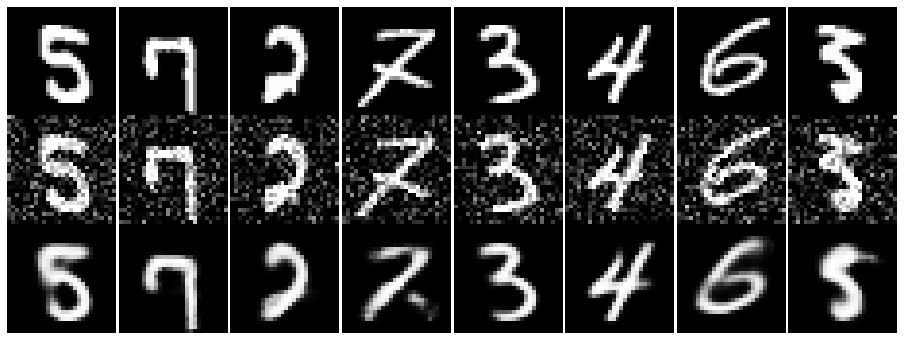

In [22]:
# Display results
xhat = model.decode(z).view(batch_size,28,28).cpu().detach().numpy()
yv = y.view(batch_size,28,28).cpu().numpy()
y_nv = y_n.view(batch_size,28,28).cpu().numpy()
img = np.concatenate((yv,y_nv,xhat))
plot_img(img,batch_size)

We can see that most of the time, the denoising result is ok. But sometimes the algorithm outputs a wrong number. This is because the optimization problem is highly nonconvex! To overcome this, we will try two smarter initializations: one with a vector of zeros, and the other one by encoding the input noisy image.

<font color='red'>Exercise:</font> 
- Implement and compare those two initializations
- compute the average PSNR over the first minibatch or the entire test set, and compare the three methods
- (Optional) Change the parameters to improve the denoising (lr, lambda, and stepsize in the gradient descent)

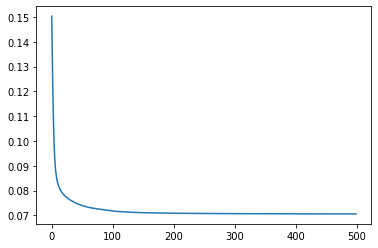

In [284]:
# Init with zeros
z = torch.zeros(batch_size,latent_dim).requires_grad_()
# Gradient descent
mse_tot_zeros = []
for e in trange(epochs):
    y_ = model.decode(z)
    mse = torch.mean((y_.view(-1)-y_n.view(-1))**2)+lambda_*torch.mean(z**2)
    mse.backward()
    with torch.no_grad():
        z -= lr*2/(2+e/10)*z.grad
        z.grad.zero_()
    mse_tot_zeros.append(mse.item())
    
plt.plot(mse_tot_zeros)

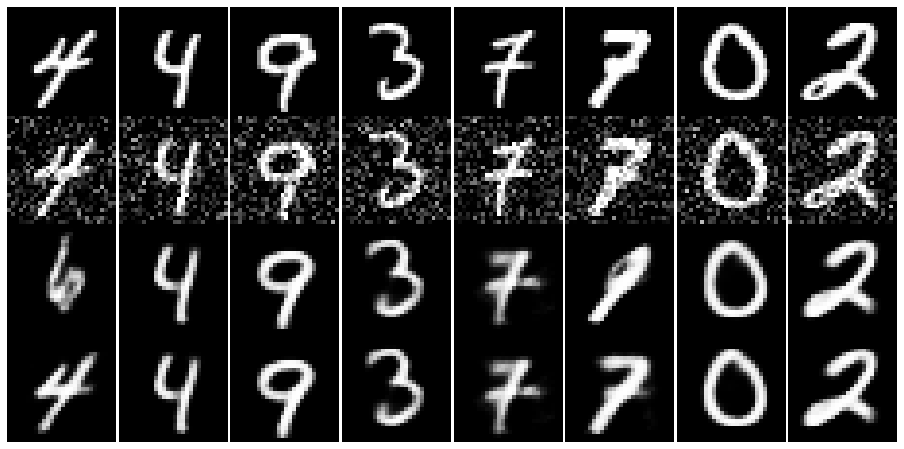

In [285]:
# Display results
xhat_zeros = model.decode(z).view(batch_size,28,28).cpu().detach().numpy()
img = np.concatenate((yv,y_nv,xhat, xhat_zeros))
plot_img(img,batch_size)

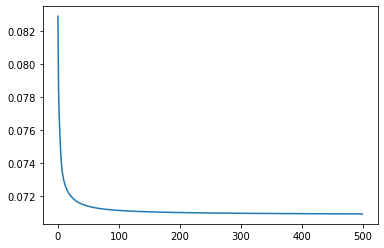

In [286]:
# Encode noisy image
z = model.reparameterize(*model.encode(y_n)).cpu().detach().requires_grad_()
# Gradient descent
mse_tot_n = []
for e in trange(epochs):
    y_ = model.decode(z)
    mse = torch.mean((y_.view(-1)-y_n.view(-1))**2)+lambda_*torch.mean(z**2)
    mse.backward()
    with torch.no_grad():
        z -= lr*2/(2+e/10)*z.grad
        z.grad.zero_()
    mse_tot_n.append(mse.item())
    
plt.plot(mse_tot_n)

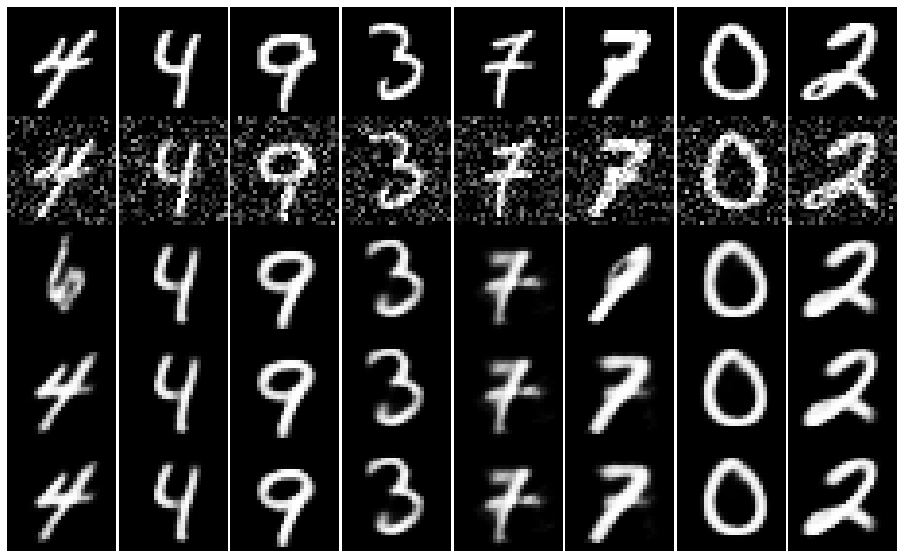

In [287]:
# Display results
xhat_noisy = model.decode(z).view(batch_size,28,28).cpu().detach().numpy()
img = np.concatenate((yv,y_nv,xhat, xhat_zeros, xhat_noisy))
plot_img(img,batch_size)

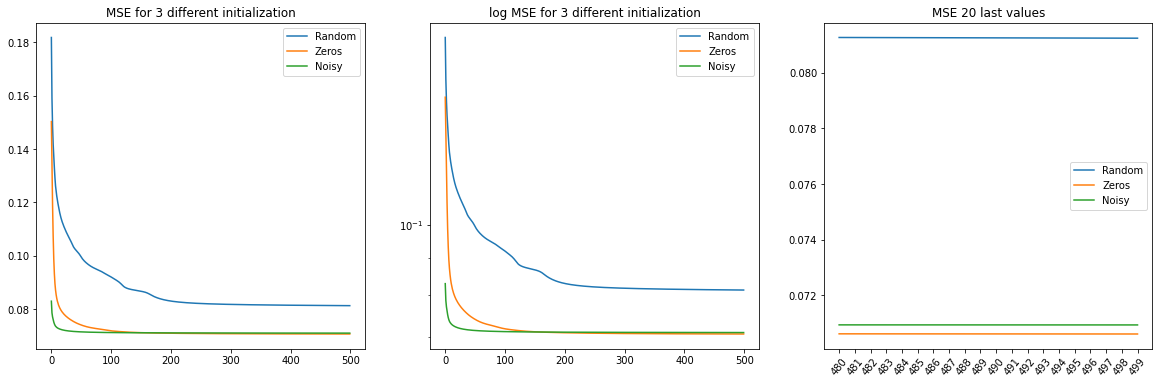

In [292]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(mse_tot, label="Random")
plt.plot(mse_tot_zeros, label="Zeros")
plt.plot(mse_tot_n, label="Noisy")
plt.title("MSE for 3 different initialization")
plt.legend()

plt.subplot(1,3,2)
plt.semilogy(mse_tot, label="Random")
plt.semilogy(mse_tot_zeros, label="Zeros")
plt.semilogy(mse_tot_n, label="Noisy")
plt.title("log MSE for 3 different initialization")
plt.legend()

nb_end_value = 20
ax = plt.subplot(1,3,3)
ax.plot(mse_tot[-nb_end_value:], label="Random")
ax.plot(mse_tot_zeros[-nb_end_value:], label="Zeros")
ax.plot(mse_tot_n[-nb_end_value:], label="Noisy")
ax.set_title(f"MSE {nb_end_value} last values")
plt.xticks(range(nb_end_value), rotation=50)
ax.set_xticklabels([str(i) for i in range(len(mse_tot)-nb_end_value,len(mse_tot))])
ax.legend()
plt.show()

## 3. Application to another inverse problem

<font color='red'>Exercise:</font> apply the above restoration method to an inverse problem. Chose the problem you want: inpainting, deblurring, super-resolution, etc.

### Inpainting

In [293]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import cv2

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [372]:
batch_size = 8
latent_dim = 20
test_loader = DataLoader(MNIST('data', train=False, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
X_batch, _ = next(iter(test_loader))

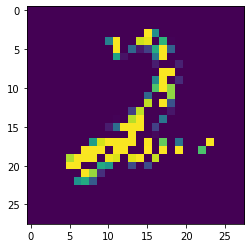

In [373]:
im = X_batch[0].view(28,28)
mask = torch.rand_like(im) > 0.5
im_masked = im.detach().clone()
im_masked[mask] = 0
plt.imshow(im_masked)

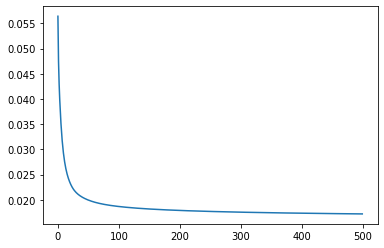

In [374]:
epoch = 500 # Number of iterations of the gradient descent
lambda_ = 1e-2 # Lambda parameter for extra regularization
lr = 100 # learning rate

# Get test data, add noise
y = X_batch.to(device).view(batch_size, 28*28)
mask = torch.rand_like(X_batch.view(batch_size, 28*28)) > 0.4
y_m = y.detach().clone()
y_m[mask] = 0

# init from img
z = model.reparameterize(*model.encode(y_m)).cpu().detach().requires_grad_()
# Gradient descent
mse_tot_mask = []
for e in trange(epoch):
    y_ = model.decode(z)
    mse = torch.mean(((y_.view(-1)-y_m.view(-1))**2)[~mask.view(-1)])+lambda_*torch.mean(z**2)
    mse.backward()
    with torch.no_grad():
        z -= lr*2/(2+e/10)*z.grad
        z.grad.zero_()
    mse_tot_mask.append(mse.item())
    
plt.plot(mse_tot_mask)

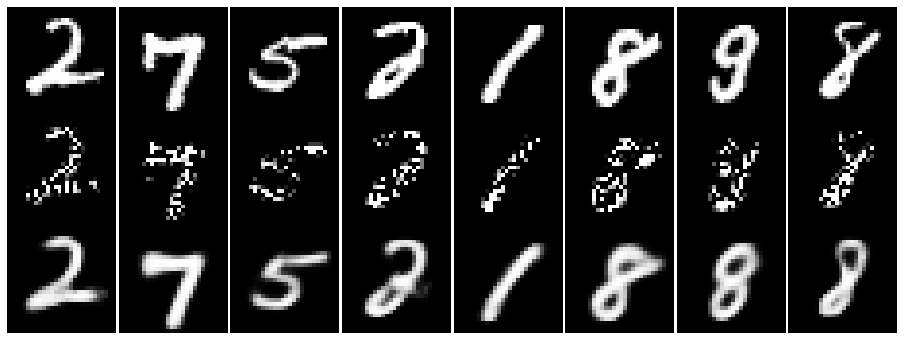

In [375]:
# Display results
xhat_mask = model.decode(z).view(batch_size,28,28).cpu().detach().numpy()
yv = y.view(batch_size,28,28).cpu().numpy()
y_mv = y_m.view(batch_size,28,28).cpu().numpy()
img = np.concatenate((yv,y_mv,xhat_mask))
plot_img(img,batch_size)

## 4. Application to more complex images with a deeper generative network
<font color='red'>Exercise:</font> consider a more complex dataset such as fashion MNIST, celebA, etc, along with a deeper and convolutional network. To avoid the training step which can be long and sometimes tricky, you can/should use a pre-trained network. Some ideas :
- The DCGAN you already used in a previous class with Dennis Wilson
- <a href="https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_dcgan/">Another pre-trained DCGAN</a>
- An invertible Neural network called Glow, which can be downloaded <a href="https://github.com/CACTuS-AI/GlowIP">here for several datasets</a>

In [ ]:
# Your answer, or your results in a separate code

In [3]:
import numpy as np
from tqdm.autonotebook import trange, tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [4]:
import torch
use_gpu = True if torch.cuda.is_available() else False

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=use_gpu)


Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/archive/hub.zip" to /root/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/DCGAN_fashionGen-1d67302.pth" to /root/.cache/torch/hub/checkpoints/DCGAN_fashionGen-1d67302.pth



Average network found !


In [5]:
num_images = 8
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


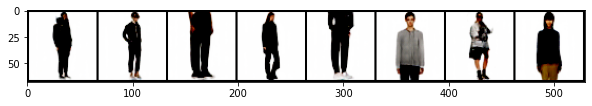

In [6]:
# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(generated_images).permute(1, 2, 0).cpu().numpy())

In [7]:
generated_images.shape

torch.Size([8, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


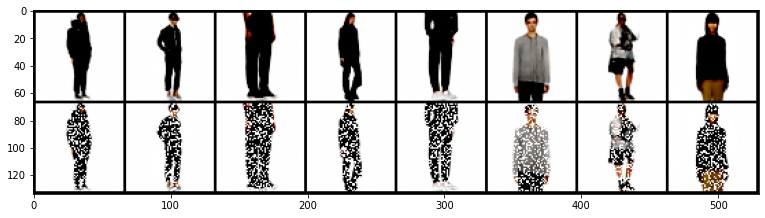

In [8]:
batch_size = num_images
y = generated_images.view(batch_size, 3, np.prod(generated_images.shape[2:]))
mask = torch.rand((y.shape[0], *y.shape[2:])) > 0.7
mask = torch.stack([mask for i in range(3)], dim=1)
y_m = y.detach().clone()
y_m[mask] = 1
y_dcganv = y_m.view(batch_size,3,64,64).cpu().numpy()
img = np.concatenate((generated_images,y_dcganv))

plt.figure(figsize=(13,10))
plt.imshow(torchvision.utils.make_grid(torch.tensor(img)).permute(1, 2, 0).cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


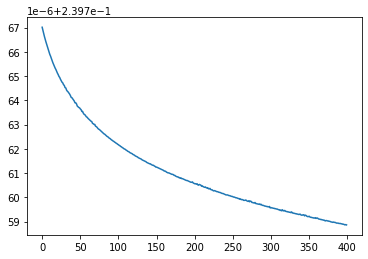

In [9]:
epoch = 400 # Number of iterations of the gradient descent
lambda_ = 1e-3 # Lambda parameter for extra regularization
lr = 100 # learning rate

# Get test data, add noise
batch_size = num_images
y = generated_images.view(batch_size, 3, np.prod(generated_images.shape[2:]))
mask = torch.rand((y.shape[0], *y.shape[2:])) > 0.9
mask = torch.stack([mask for i in range(3)], dim=1)
y_m = y.detach().clone()
y_m[mask] = 1

# init from img
z = torch.rand(batch_size,120).requires_grad_()
# Gradient descent
mse_tot_dcgan = []
for e in trange(epoch):
    y_ = model.test(z)
    mse = torch.mean(((y_.view(-1)-y_m.view(-1))**2)[~mask.view(-1)])+lambda_*torch.mean(z**2) # Take MSe for pixels that are not in the mask
    mse.backward()
    with torch.no_grad():
        z -= lr*2/(2+e/10)*z.grad
        z.grad.zero_()
    mse_tot_dcgan.append(mse.item())
    
plt.plot(mse_tot_dcgan)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


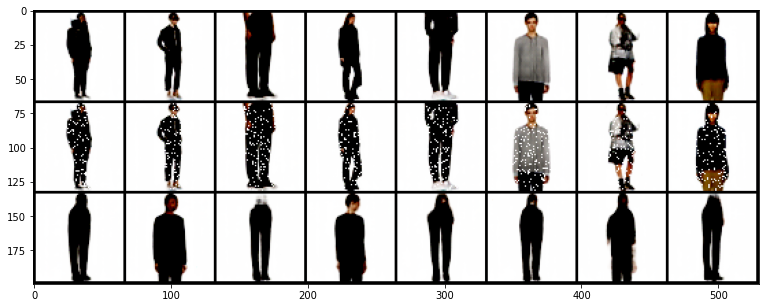

In [10]:
xhat_dcgan = model.test(z).view(batch_size,3,64,64).cpu().detach().numpy()
y_dcganv = y_m.view(batch_size,3,64,64).cpu().numpy()
img = np.concatenate((generated_images,y_dcganv,xhat_dcgan))

plt.figure(figsize=(13,10))
plt.imshow(torchvision.utils.make_grid(torch.tensor(img)).permute(1, 2, 0).cpu().numpy())

Unfortunately the Network is not learning well as we can see with the evolution of the loss and the images it generate at the end. Results are even worse when initialazing with zeros instead of randoms.

## 5. A synthesis approach (Bonus)
This approach is efficient but it is unlikely to generalize well to various unseen images. Indeed, the estimation is constrained to be be in the range of the generator/decoder. To circumvent this, we proposed in a recente <a href="https://arxiv.org/pdf/2101.08661">paper</a> to solve the problem in the image space instead of the latent space, the neural network being used only for regularization purpose. The problem then writes
$$\hat x = \arg \min_x \frac{1}{2}\|y-Ax\|_2^2 + \lambda \|E(x)\|_2^2.$$

<font color='red'>Exercise:</font> apply this analysis approach and compare with the previous results. You can in particular compare the generalization capacity of both methods, for images that are quite different from those in  training set.

In [ ]:
# Your answer, or your results in a separate code